# Simple trend-following strategy switching between the S&P 500 and Gold
### The strategy:
#### (1) Ensure the trend of 52-week SPX high is up
#### (2) Ensure the trend of the SPX is up
#### (3) If (1) or (2) is in an uptrend, calculate the rate of change of SPY and GLD for the last 150 days
#### (4) Buy the strongest of SPX or Gold, or the one that qualifies (>0). If (3) < 0, then stay in cash

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import yfinance as yf
import requests
import pandas_datareader as pdr
from datetime import datetime as dt
import random
import seaborn as sns
import matplotlib.ticker as mtick

In [2]:
tickers = ['SPY', 'GC=F']

df = yf.download(tickers, period='max', interval="1d")
df = df['Adj Close']
df.rename(columns={'SPY':'SPX', 'GC=F': 'Gold'}, inplace=True) 
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  2 of 2 completed


,Gold,SPX
Date,,
2000-08-30,273.899994,98.630531
2000-08-31,278.299988,99.942574
2000-09-01,277.000000,100.045128
2000-09-05,275.799988,99.245590
2000-09-06,274.200012,98.117996


<AxesSubplot:xlabel='Date'>

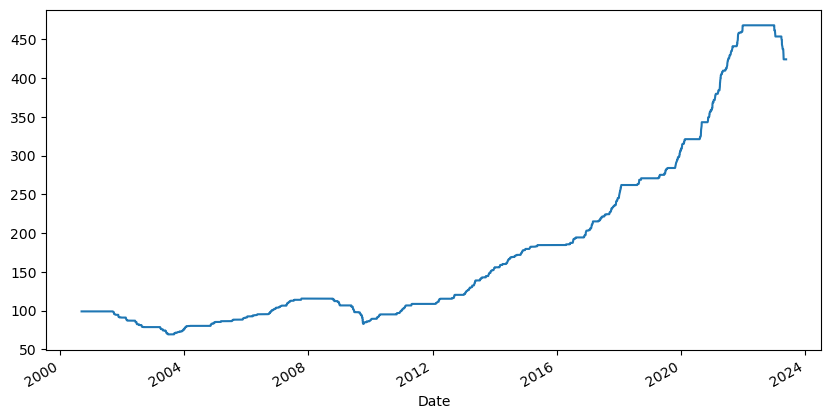

In [5]:
# 52 Week High Indicator
df['52w_high'] = 0
for i in range(df.shape[0]):
    if i < 252:
        df.iloc[i,2]  = df.SPX[1:i,].max()
    else:
        df.iloc[i,2] = df.SPX[i-252:i,].max()
df.dropna(inplace=True)
df.iloc[:,2].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

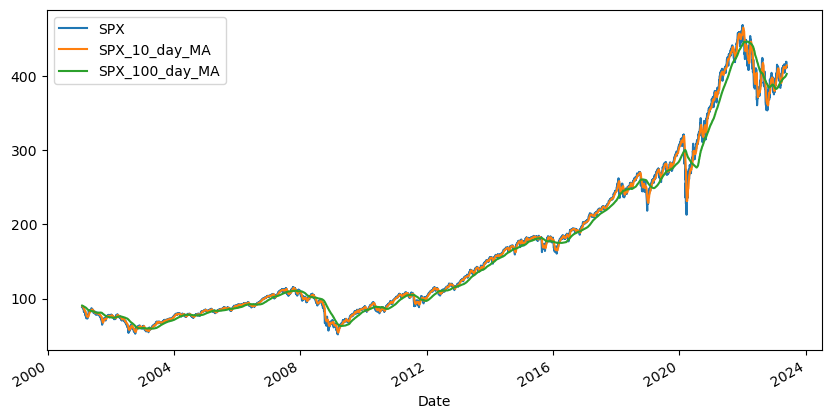

In [6]:
df['52w_10_day_MA'] = df["52w_high"].rolling(window=10).mean().shift() #shift to ensure no lookahead bias
df['52w_100_day_MA'] = df["52w_high"].rolling(window=100).mean().shift()

df['SPX_10_day_MA'] = df.SPX.rolling(window=10).mean().shift()
df['SPX_100_day_MA'] = df.SPX.rolling(window=100).mean().shift()
df.dropna(inplace=True)
df.loc[:,["SPX","SPX_10_day_MA","SPX_100_day_MA"]].plot(figsize=(10,5))

In [7]:
# Check that the trend of the 52w High and SPY is up
df['SPX_Signal'] = np.where(df['SPX_10_day_MA'] > df['SPX_100_day_MA'], 1, 0)
df['52w_Signal'] = np.where(df['52w_10_day_MA'] > df['52w_100_day_MA'], 1, 0)

# If S&P 500 or 52 week high is in an uptrend, overall trend indicator positive
df['Trend_signal'] = np.where(np.logical_or(df['SPX_Signal'] == 1, df['52w_Signal'] == 1), 1, 0)
df.dropna(inplace=True)
df.head()

,Gold,SPX,52w_high,52w_10_day_MA,52w_100_day_MA,SPX_10_day_MA,SPX_100_day_MA,SPX_Signal,52w_Signal,Trend_signal
Date,,,,,,,,,,
2001-02-02,267.100006,88.927422,98.958542,98.958542,98.958542,89.885421,90.598212,0,0,0
2001-02-05,265.200012,89.580536,98.958542,98.958542,98.958542,89.937167,90.504665,0,0,0
2001-02-06,263.299988,89.316643,98.958542,98.958542,98.958542,89.995468,90.419085,0,0,0
2001-02-07,262.799988,88.854836,98.958542,98.958542,98.958542,89.957290,90.338042,0,0,0
2001-02-08,260.100006,87.819099,98.958542,98.958542,98.958542,89.846132,90.249818,0,0,0


In [8]:
df.drop(columns=["52w_high","52w_10_day_MA","52w_100_day_MA","SPX_10_day_MA","SPX_100_day_MA"], inplace=True)

# Calc. 12 mth return
df['SPX_ROC_Ind'] = round(df.SPX.pct_change(periods=252).shift() * df['Trend_signal'],4)
df['Gold_ROC_Ind'] = round(df.Gold.pct_change(periods=252).shift() * df['Trend_signal'],4)
df['Gold'] = df['Gold'].pct_change()
df['SPX'] = df['SPX'].pct_change()
df.dropna(inplace=True)
df

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind
Date,,,,,,,
2002-02-13,-0.004323,0.010622,0,0,0,-0.0000,0.0000
2002-02-14,0.001002,-0.001871,0,0,0,-0.0000,0.0000
2002-02-15,-0.004338,-0.010441,0,0,0,-0.0000,0.0000
2002-02-19,-0.017426,-0.019208,0,0,0,-0.0000,0.0000
2002-02-20,-0.003070,0.016826,0,0,0,-0.0000,0.0000
...,...,...,...,...,...,...,...
2023-05-19,0.011347,-0.001455,1,0,1,0.0441,0.0761
2023-05-22,-0.001971,0.000406,1,0,1,0.0864,0.0897
2023-05-23,-0.001215,-0.011223,1,0,1,0.0935,0.0726


In [9]:
# Daily rebalance strategy
df['Entry'] = ""
df['Strategy_DailyRebal'] = 0
df.head()

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal
Date,,,,,,,,,
2002-02-13,-0.004323,0.010622,0,0,0,-0.0,0.0,,0
2002-02-14,0.001002,-0.001871,0,0,0,-0.0,0.0,,0
2002-02-15,-0.004338,-0.010441,0,0,0,-0.0,0.0,,0
2002-02-19,-0.017426,-0.019208,0,0,0,-0.0,0.0,,0
2002-02-20,-0.003070,0.016826,0,0,0,-0.0,0.0,,0


In [13]:
# Assuming purchase as the close
for i in range(df.shape[0]-1):
    if df['SPX_ROC_Ind'][i] > 0 and df["Gold_ROC_Ind"][i] <= 0:
        df.iloc[i+1,-2] = "SPX"
        df.iloc[i+1,-1] = df['SPX'][i+1]
    elif df['SPX_ROC_Ind'][i] <= 0 and df["Gold_ROC_Ind"][i] > 0:
        df.iloc[i+1,-2] = "Gold"
        df.iloc[i+1,-1] = df['Gold'][i+1]
    elif df['SPX_ROC_Ind'][i] > 0 and df["Gold_ROC_Ind"][i] > 0:
        if df['SPX_ROC_Ind'][i] > df["Gold_ROC_Ind"][i]:
            df.iloc[i+1,-2] = "SPX"
            df.iloc[i+1,-1] = df['SPX'][i+1]
        else:
            df.iloc[i+1,-2] = "Gold"
            df.iloc[i+1,-1] = df['Gold'][i+1]
    else:
        df.iloc[i+1,-1] = 0
    
#     Adding transaction costs
    if df.iloc[i,-2] != df.iloc[i-1,-2]:
        df.iloc[i,-1] = df.iloc[i,-1]-0.0025
    

df

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal
Date,,,,,,,,,
2002-02-13,-0.004323,0.010622,0,0,0,-0.0000,0.0000,,-0.002500
2002-02-14,0.001002,-0.001871,0,0,0,-0.0000,0.0000,,0.000000
2002-02-15,-0.004338,-0.010441,0,0,0,-0.0000,0.0000,,0.000000
2002-02-19,-0.017426,-0.019208,0,0,0,-0.0000,0.0000,,0.000000
2002-02-20,-0.003070,0.016826,0,0,0,-0.0000,0.0000,,0.000000
...,...,...,...,...,...,...,...,...,...
2023-05-19,0.011347,-0.001455,1,0,1,0.0441,0.0761,Gold,0.011347
2023-05-22,-0.001971,0.000406,1,0,1,0.0864,0.0897,Gold,-0.001971
2023-05-23,-0.001215,-0.011223,1,0,1,0.0935,0.0726,Gold,-0.001215


In [16]:
# Daily Rebalance
dailyStrategy = (1+df['Strategy_DailyRebal']).cumprod()
SPX = (1+df['SPX']).cumprod()
d = {'Strategy':dailyStrategy, 'Benchmark': SPX}
df2 = pd.DataFrame(data=d)
df2

,Strategy,Benchmark
Date,,
2002-02-13,0.997500,1.010622
2002-02-14,0.997500,1.008732
2002-02-15,0.997500,0.998200
2002-02-19,0.997500,0.979027
2002-02-20,0.997500,0.995500
...,...,...
2023-05-19,6.165542,5.640016
2023-05-22,6.153390,5.642307
2023-05-23,6.145912,5.578984


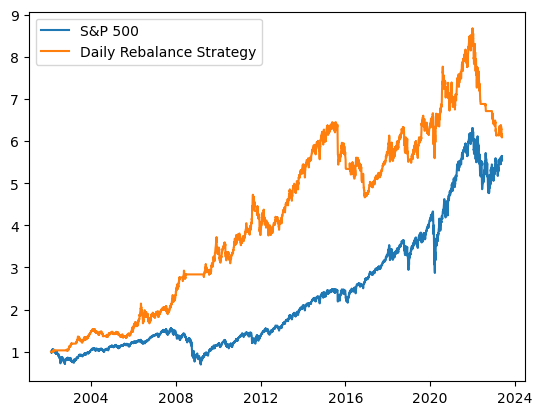

In [21]:
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, dailyStrategy, label='Daily Rebalance Strategy')
plt.legend(loc=0)

Strategy:
Max Drawdown:-29.82%
Max Drawdown Duration: 1021 days
Date of Max DrawDown: 2023-05-24 00:00:00

_____________

Benchmark:
Max Drawdown:-55.19%
Max Drawdown Duration: 1223 days
Date of Max DrawDown: 2009-03-09 00:00:00

_____________



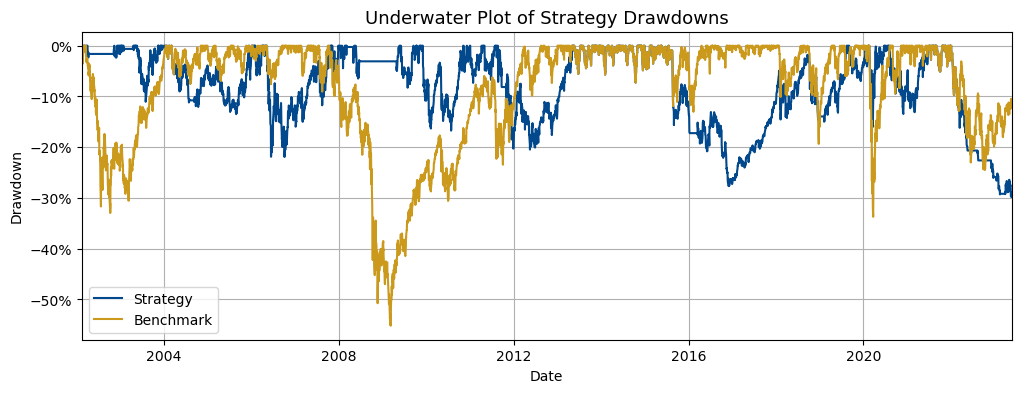

In [55]:
# DD and Return Stats
def calculate_MaxDD(dataframe, multi_frame=False, num_frames=1):
    """
    Calculates the drawdown statistics for an asset or strategy
    """
    if multi_frame==False:
        cumreturn = dataframe
        highwatermark = np.zeros(cumreturn.shape)
        drawdown = np.zeros(cumreturn.shape)
        drawdownduration = np.zeros(cumreturn.shape)

        for t in np.arange(1, cumreturn.shape[0]):
            highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
            drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
            if drawdown[t] == 0:
                drawdownduration[t] = 0
            else:
                drawdownduration[t] = drawdownduration[t - 1] + 1

        maxDD, i = np.min(drawdown), np.argmin(drawdown)
        maxDDD = np.max(drawdownduration)
        DD_Date = cumreturn.index[i]
        return f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}"
    
    else:
        for i in range(num_frames): 
            cumreturn = dataframe.iloc[:,i]
            highwatermark = np.zeros(cumreturn.shape)
            drawdown = np.zeros(cumreturn.shape)
            drawdownduration = np.zeros(cumreturn.shape)

            for t in np.arange(1, cumreturn.shape[0]):
                highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
                drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
                if drawdown[t] == 0:
                    drawdownduration[t] = 0
                else:
                    drawdownduration[t] = drawdownduration[t - 1] + 1

            maxDD, i = np.min(drawdown), np.argmin(drawdown)
            maxDDD = np.max(drawdownduration)
            DD_Date = cumreturn.index[i]
            print(f"{cumreturn.name}:")
            print(f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}\n")
            print("_____________\n")
    
def underwater_plot(dataframe, multi_frame=False, num_frames=1):
    """
    Plots the drawdown profile of an asset from the asset price dataframe
    """
    if multi_frame==False:
        cum_max = dataframe.cummax()
        drawdowns = (dataframe - cum_max) / cum_max
        drawdowns = round(drawdowns,2)
        
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(drawdowns.index, drawdowns, color="lightcoral")
        ax.fill_between(drawdowns.index, drawdowns, 0, where=drawdowns < 0, interpolate=True, color="whitesmoke")
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        ax.grid()
        ax.set_xlim(min(dataframe.index),max(dataframe.index))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Underwater Plot of Strategy Drawdowns',fontsize=13)
        ax.set_xlabel('Date')
        ax.set_ylabel('Drawdown')
        for i in range(num_frames): 
            cum_max = dataframe.iloc[:,i].cummax()
            drawdowns = (dataframe.iloc[:,i] - cum_max) / cum_max
            drawdowns = drawdowns
            ax.plot(drawdowns.index, drawdowns, color=list(np.random.uniform(0,1, size=3)), label=dataframe.columns[i])
        ax.legend(loc=0)
        ax.grid()
        ax.set_xlim(min(dataframe.index),max(dataframe.index))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))


underwater_plot(df2, multi_frame=True, num_frames=2)
calculate_MaxDD(df2, multi_frame=True, num_frames=2)

In [30]:
# Reformat to monthly data
df_m = df.copy()
df_m = df.loc[df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())]
eom = df_m.index
eom.freq=None
eom = eom.tolist()
eom = eom[:-1] # Omitting the last date as it's usually incorrect
df_index = df_m.index.tolist()
print(eom[0] == df_index[0])

True


In [32]:
# Monthly rebalance strategy
df["Strategy_mthRebal"] = 0

for i in eom:
    if df['Entry'][i] == 'SPX':
        df["Strategy_mthRebal"][i:] = df.SPX[i:]
        df["Strategy_mthRebal"][i] = df.SPX[i] - 0.0025 # adding transaction costs
    elif df['Entry'][i] == 'Gold':
        df["Strategy_mthRebal"][i:] = df.Gold[i:]
        df["Strategy_mthRebal"][i] = df.Gold[i] - 0.0025
    else:
        df["Strategy_mthRebal"][i:] = 0     

df

C:\Users\44791\AppData\Local\Temp\ipykernel_21132\2700016727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Strategy_mthRebal"][i:] = 0
C:\Users\44791\AppData\Local\Temp\ipykernel_21132\2700016727.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Strategy_mthRebal"][i:] = df.Gold[i:]


,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal,Strategy_mthRebal
Date,,,,,,,,,,
2002-02-13,-0.004323,0.010622,0,0,0,-0.0000,0.0000,,-0.002500,0.000000
2002-02-14,0.001002,-0.001871,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2002-02-15,-0.004338,-0.010441,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2002-02-19,-0.017426,-0.019208,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2002-02-20,-0.003070,0.016826,0,0,0,-0.0000,0.0000,,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-05-19,0.011347,-0.001455,1,0,1,0.0441,0.0761,Gold,0.011347,0.011347
2023-05-22,-0.001971,0.000406,1,0,1,0.0864,0.0897,Gold,-0.001971,-0.001971
2023-05-23,-0.001215,-0.011223,1,0,1,0.0935,0.0726,Gold,-0.001215,-0.001215


In [39]:
# Monthly Rebalance
mthStrategy = (1+df['Strategy_mthRebal']).cumprod()
e = {'Strategy':mthStrategy, 'Benchmark': SPX}
df3 = pd.DataFrame(data=e)
df3

,Strategy,Benchmark
Date,,
2002-02-13,1.000000,1.010622
2002-02-14,1.000000,1.008732
2002-02-15,1.000000,0.998200
2002-02-19,1.000000,0.979027
2002-02-20,1.000000,0.995500
...,...,...
2023-05-19,4.396581,5.640016
2023-05-22,4.387915,5.642307
2023-05-23,4.382583,5.578984


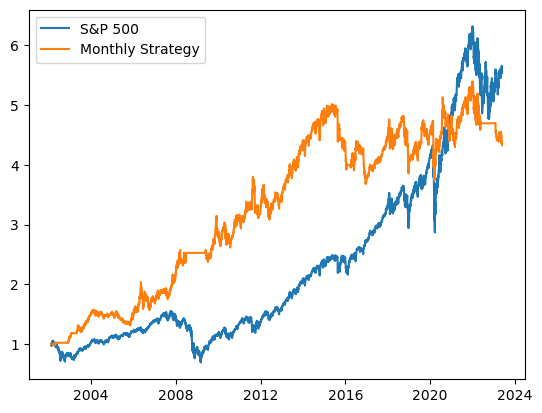

In [40]:
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, mthStrategy, label='Monthly Strategy')
plt.legend(loc=0)

Strategy:
Max Drawdown:-26.55%
Max Drawdown Duration: 1307 days
Date of Max DrawDown: 2016-12-15 00:00:00

_____________

Benchmark:
Max Drawdown:-55.19%
Max Drawdown Duration: 1223 days
Date of Max DrawDown: 2009-03-09 00:00:00

_____________

None


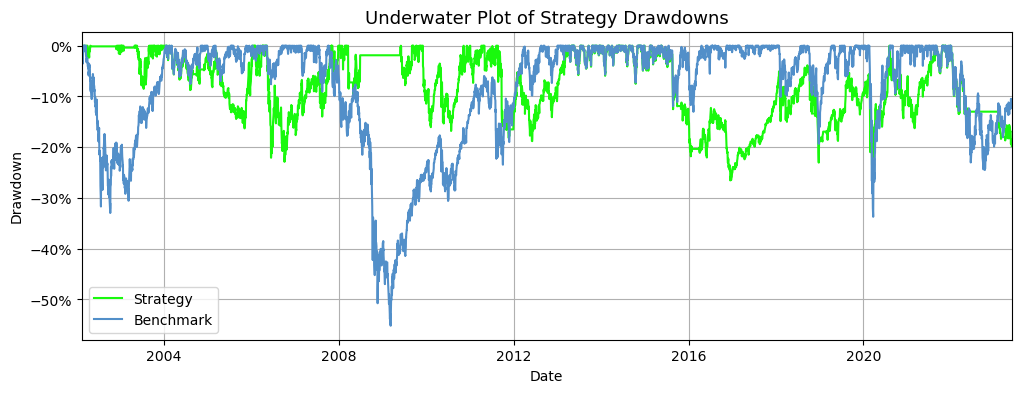

In [45]:
print(calculate_MaxDD(df3, multi_frame=True, num_frames=2))
underwater_plot(df3, multi_frame=True, num_frames=2)

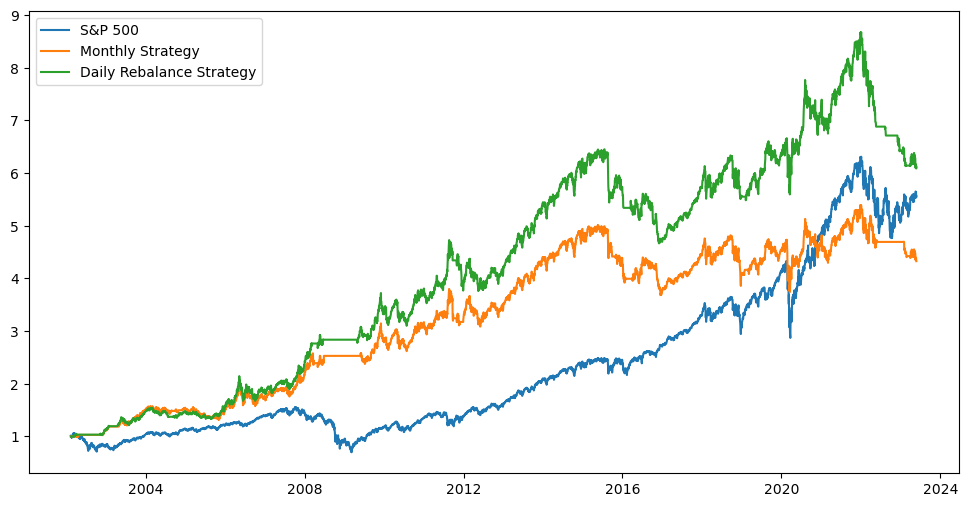

In [56]:
plt.figure(figsize=(12,6))
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, mthStrategy, label='Monthly Strategy')
plt.plot(df.index, dailyStrategy, label='Daily Rebalance Strategy')
plt.legend(loc=0)

In [57]:
# Return Statistics
excess_mthly = df['Strategy_mthRebal'] - 0.04/252
mthly_sharpe = np.sqrt(252) * np.mean(excess_mthly) / np.std(excess_mthly)

excess_daily = df['Strategy_DailyRebal'] - 0.04/252
daily_sharpe = np.sqrt(252) * np.mean(excess_daily) / np.std(excess_daily)
print(f"Sharpe Ratio:\nDaily Rebalance: {daily_sharpe}\nMonthly Rebalance: {mthly_sharpe}")

Sharpe Ratio:
Daily Rebalance: 0.38862250175664886
Monthly Rebalance: 0.2713401344535224
